In [1]:
# import the relevant libraries
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PolynomialFeatures
from tabulate import tabulate
from statsmodels.tools import add_constant
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
# Load the data 
df = pd.read_csv('Olist_remove_co_correlated_no_price.csv')
df.head()

,item,product_id,freight_value,payment_sequential,payment_installments,order_purchase_timestamp,review_score,postal_code,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,sales_revenue
0,1,4244733e06e7ecb4970a6e2683c13e61,13.29,1,2,2017-09-13 08:59:00,5,28013,cool_stuff,650.0,28.0,9.0,14.0,58.9
1,1,4244733e06e7ecb4970a6e2683c13e61,17.96,1,1,2017-06-28 11:52:00,5,75800,cool_stuff,650.0,28.0,9.0,14.0,55.9
2,1,4244733e06e7ecb4970a6e2683c13e61,18.33,1,2,2018-05-18 10:25:00,4,30720,cool_stuff,650.0,28.0,9.0,14.0,64.9
3,1,4244733e06e7ecb4970a6e2683c13e61,16.17,1,3,2017-08-01 18:38:00,5,83070,cool_stuff,650.0,28.0,9.0,14.0,58.9
4,1,4244733e06e7ecb4970a6e2683c13e61,13.29,1,4,2017-08-10 21:48:00,5,36400,cool_stuff,650.0,28.0,9.0,14.0,58.9


In [3]:
# Drop the defined columns from the dataframe to form feature set 'X'.
X = df.drop(['sales_revenue', 'order_purchase_timestamp','product_category_name'], axis=1)

# Assign 'sales_revenue' column as the target variable 'y'.
y = df['sales_revenue']

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Keep a copy of the Product IDs for the test set before dropping from X
X_Product_IDs = X['product_id'].copy()

# Drop the Product ID from X
X = X.drop('product_id', axis=1)

# Split the data into train/test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Split train_val set into separate training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=0)

# Define preprocessing for numerical columns (scale them)
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the pipeline to train a linear regression model on the training set
pipeline.fit(X_train, y_train)

# Make predictions on the test set using the fitted model
y_pred_test = pipeline.predict(X_test)

# Create a DataFrame for the predictions, indexed by Product ID
df_predictions = pd.DataFrame({
    'product_id': X_Product_IDs.loc[X_test.index],
    'Actual': y_test,
    'Predicted': y_pred_test
})

print(df_predictions)

                             product_id   Actual   Predicted
79496  cf3aebf1fe742d73907fed51ead1945c   119.90  221.701420
693    1fe8e6e01596885617fa1c90d29c2f81    81.56   88.257670
18245  db0e75ba1fc6537d68f2676f3b67d07f   249.99  174.605694
30359  41c24b8ce92d1a2cac62db5edfd088b2    99.90  127.073867
63301  e0cf79767c5b016251fe139915c59a26    29.90   86.553694
...                                 ...      ...         ...
39731  e9def91e99c8ecb7c5cef5e31506a056    69.99   54.570225
92284  06601c3059e35a3bf65e72f2fd2ac626   109.90   67.937309
23099  26e253f334cf93847fcbf6e9faf51eb4   169.00  242.010516
29587  ee3d532c8a438679776d222e997606b3  1200.00  634.871487
28118  542b3d80712d51eefe3a3cd1c5f4e8fe    42.90   73.909633

[23073 rows x 3 columns]


In [5]:
# Create a dataframe for the coefficients
coef_df = pd.DataFrame(pipeline.named_steps['regressor'].coef_, X.columns, columns=['Coefficient'])

# Append the intercept
coef_df = coef_df.append(pd.DataFrame([pipeline.named_steps['regressor'].intercept_], ['Intercept'], columns=['Coefficient']))

# Display the dataframe
print(coef_df)

                      Coefficient
item                    35.359548
freight_value           60.292958
payment_sequential       2.513753
payment_installments    40.062329
review_score             0.855485
postal_code             -6.541688
product_weight_g        26.268037
product_length_cm       -5.376298
product_height_cm        3.557802
product_width_cm        -1.561004
Intercept              135.700846


C:\Users\Work&Study\AppData\Local\Temp\ipykernel_13644\1603916518.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coef_df = coef_df.append(pd.DataFrame([pipeline.named_steps['regressor'].intercept_], ['Intercept'], columns=['Coefficient']))


In [6]:
df_compare = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test})
print(df_compare)

        Actual   Predicted
79496   119.90  221.701420
693      81.56   88.257670
18245   249.99  174.605694
30359    99.90  127.073867
63301    29.90   86.553694
...        ...         ...
39731    69.99   54.570225
92284   109.90   67.937309
23099   169.00  242.010516
29587  1200.00  634.871487
28118    42.90   73.909633

[23073 rows x 2 columns]


In [7]:
import statsmodels.api as sm

# Assuming X and y are your predictors and target, and that X includes an intercept column of ones
model = sm.OLS(y, X)
results = model.fit()

# This will display the summary statistics table
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:          sales_revenue   R-squared (uncentered):                   0.445
Model:                            OLS   Adj. R-squared (uncentered):              0.445
Method:                 Least Squares   F-statistic:                              9249.
Date:                Fri, 23 Jun 2023   Prob (F-statistic):                        0.00
Time:                        17:07:32   Log-Likelihood:                     -7.6920e+05
No. Observations:              115365   AIC:                                  1.538e+06
Df Residuals:                  115355   BIC:                                  1.539e+06
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [8]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor


# vif = df
# vif["Feature"] = X.columns
# vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [9]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_test))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_test))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))

Mean Absolute Error: 84.56768431255598
Mean Squared Error: 34049.545857933765
Root Mean Squared Error: 184.5251903072688


In [10]:
# Create a dataframe for test set predictions
df_test_predictions = pd.DataFrame(y_pred_test, columns=['Predicted'], index=y_test.index)

# Merge this dataframe with the actuals, using the common index
df_test_combined = y_test.to_frame().join(df_test_predictions)

# Now 'sales_revenue' is your actual values and 'Predicted' is the model's predictions
print(df_test_combined[['sales_revenue', 'Predicted']])

       sales_revenue   Predicted
79496         119.90  221.701420
693            81.56   88.257670
18245         249.99  174.605694
30359          99.90  127.073867
63301          29.90   86.553694
...              ...         ...
39731          69.99   54.570225
92284         109.90   67.937309
23099         169.00  242.010516
29587        1200.00  634.871487
28118          42.90   73.909633

[23073 rows x 2 columns]


In [11]:
print(y_test.shape)
print(y_pred_test.shape)

(23073,)
(23073,)


In [12]:
import statsmodels.api as sm

# Assuming X and y are your predictors and target, and that X includes an intercept column of ones
model = sm.OLS(y, X)
results = model.fit()

# This will display the summary statistics table
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:          sales_revenue   R-squared (uncentered):                   0.445
Model:                            OLS   Adj. R-squared (uncentered):              0.445
Method:                 Least Squares   F-statistic:                              9249.
Date:                Fri, 23 Jun 2023   Prob (F-statistic):                        0.00
Time:                        17:07:32   Log-Likelihood:                     -7.6920e+05
No. Observations:              115365   AIC:                                  1.538e+06
Df Residuals:                  115355   BIC:                                  1.539e+06
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [13]:
import numpy as np

# Assuming y_test and y_pred_test are your actual and predicted values

# Calculate MAPE
mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

# Calculate MPE
mpe = np.mean((y_test - y_pred_test) / y_test) * 100

# Calculate PRMSE
prmse = (np.sqrt(np.mean((y_test - y_pred_test) ** 2)) / np.mean(y_test)) * 100

# Print the metrics
print("Mean Absolute Percentage Error (MAPE): {:.2f}%".format(mape))
print("Mean Percentage Error (MPE): {:.2f}%".format(mpe))
print("Percentage Root Mean Squared Error (PRMSE): {:.2f}%".format(prmse))

Mean Absolute Percentage Error (MAPE): 102.54%
Mean Percentage Error (MPE): -78.38%
Percentage Root Mean Squared Error (PRMSE): 135.16%


In [14]:
from sklearn.metrics import mean_squared_error

# Assuming y_train and y_test are the actual target values
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print("Train MSE:", train_mse)
print("Test MSE:", test_mse)

Train MSE: 31871.08712440702
Test MSE: 34049.545857933765


In [15]:
import numpy as np

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

Train RMSE: 178.5247521337224
Test RMSE: 184.5251903072688


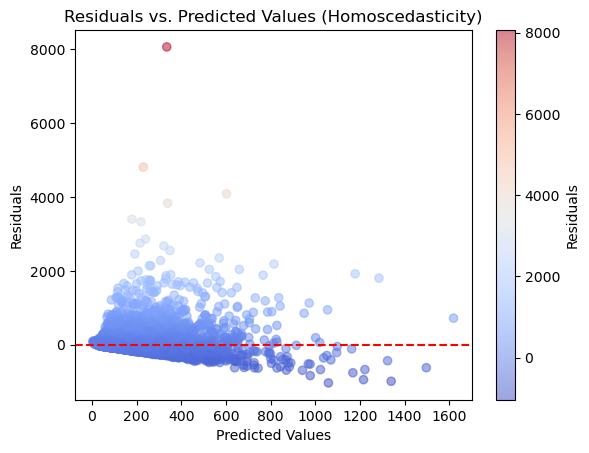

In [16]:
residuals = y_test - y_pred_test

# Plotting the residuals against the predicted values with color-coded data points
import matplotlib.pyplot as plt
plt.scatter(y_pred_test, residuals, alpha=0.5, c=residuals, cmap='coolwarm')
plt.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values (Homoscedasticity)')
plt.colorbar(label='Residuals')  # Add a colorbar indicating the range of residuals
plt.show()

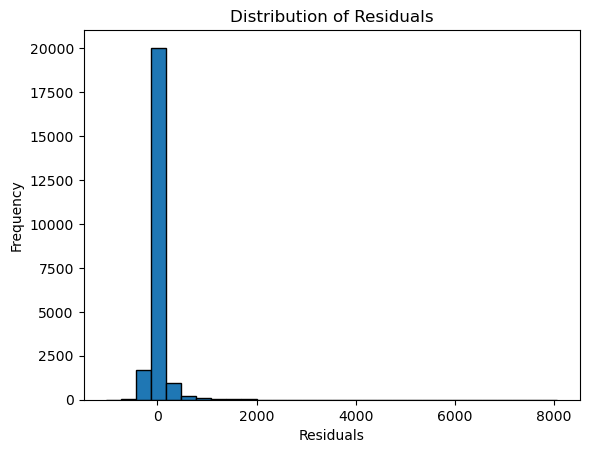

In [17]:
# Plot a histogram of the residuals
plt.hist(residuals, bins=30, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

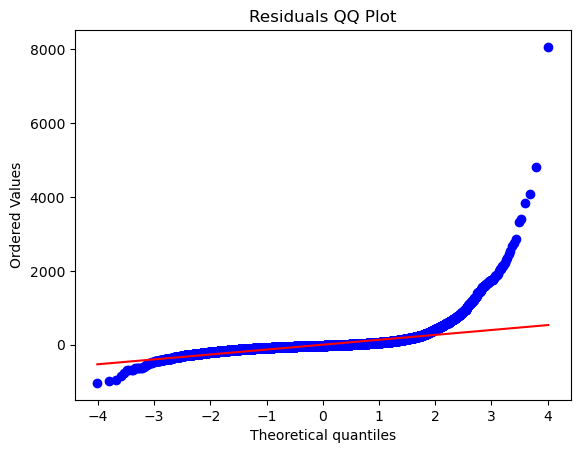

In [18]:
import scipy.stats as stats

stats.probplot(residuals, plot=plt)
plt.title('Residuals QQ Plot')
plt.show()

In [19]:
from statsmodels.stats.stattools import durbin_watson

dw = durbin_watson(residuals)
print('Durbin-Watson:', dw)

Durbin-Watson: 2.000409738091007


In [20]:
import pandas as pd

# Create a DataFrame with the predicted values and residuals
residuals_df = pd.DataFrame({'Predicted Values': y_pred_test, 'Residuals': residuals})

# Display the DataFrame
print(residuals_df)

       Predicted Values   Residuals
79496        221.701420 -101.801420
693           88.257670   -6.697670
18245        174.605694   75.384306
30359        127.073867  -27.173867
63301         86.553694  -56.653694
...                 ...         ...
39731         54.570225   15.419775
92284         67.937309   41.962691
23099        242.010516  -73.010516
29587        634.871487  565.128513
28118         73.909633  -31.009633

[23073 rows x 2 columns]


In [21]:
# Merge with 'order_purchase_timestamp' information
df_test_combined = df_test_combined.join(df['order_purchase_timestamp'])

# Convert 'order_purchase_timestamp' to datetime if it isn't already
df_test_combined['order_purchase_timestamp'] = pd.to_datetime(df_test_combined['order_purchase_timestamp'])

# Set 'order_purchase_timestamp' as the index
df_test_combined.set_index('order_purchase_timestamp', inplace=True)

# Sort the DataFrame by the index
df_test_combined.sort_index(inplace=True)

# Now df_test_combined contains both the actual and predicted sales revenue, in chronological order
print(df_test_combined[['sales_revenue', 'Predicted']])

                          sales_revenue   Predicted
order_purchase_timestamp                           
2016-10-03 21:01:00               21.50   68.807810
2016-10-03 22:31:00               29.99  159.733622
2016-10-03 22:51:00               74.90  105.164580
2016-10-04 09:59:00               89.90  152.594844
2016-10-04 10:16:00              189.00  249.318452
...                                 ...         ...
2018-08-29 08:46:00              457.75  268.649192
2018-08-29 09:14:00               99.00   42.658176
2018-08-29 09:48:00              169.80   50.585273
2018-08-29 11:06:00              109.90   67.937309
2018-08-29 15:00:00               84.99   49.711685

[23073 rows x 2 columns]


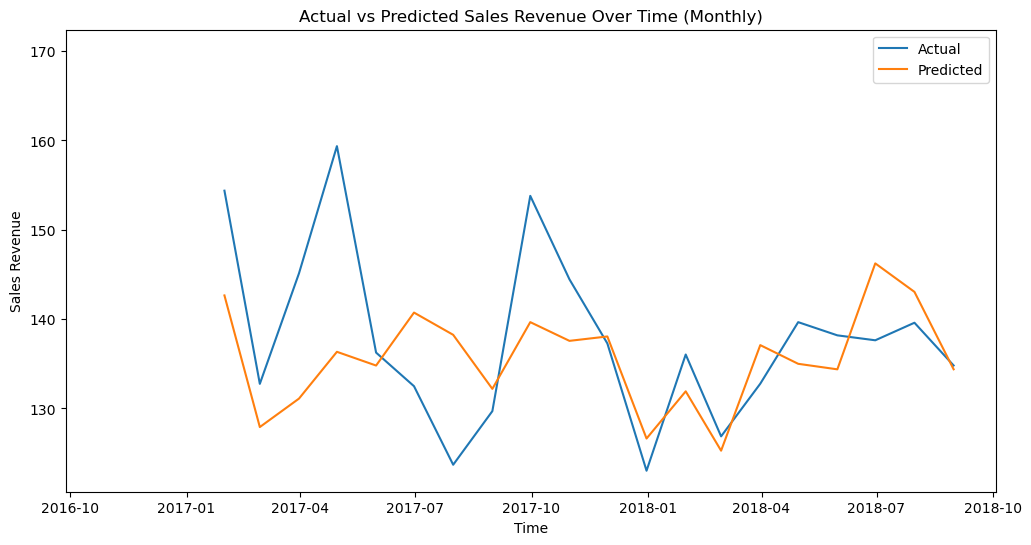

In [22]:
# Resample the dataframe to monthly frequency, aggregating with mean
df_monthly = df_test_combined.resample('M').mean()

# Create a line plot of actual and predicted values
plt.figure(figsize=(12,6))
plt.plot(df_monthly.index, df_monthly['sales_revenue'], label='Actual')
plt.plot(df_monthly.index, df_monthly['Predicted'], label='Predicted')

# Add labels, title, and legend
plt.xlabel('Time')
plt.ylabel('Sales Revenue')
plt.title('Actual vs Predicted Sales Revenue Over Time (Monthly)')
plt.legend()

# Show the plot
plt.show()